# DL1 Assignment2 - Q1.1 draft code

This is a small help from us to save you some coding. This notebook is **not** graded, you are free to edit it.

Further advise:
1. Start with File/Save a copy in Drive
2. Set GPU usage under Runtime/Change runtime type/Hardware accelerator.

In [2]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.7 MB/s eta 0:00:00


In [3]:

import torch
from torch import nn
import timm
from torchvision import models
from matplotlib import pyplot as plt
from typing import Callable

%matplotlib inline

In [4]:
def vit_s_8():
    """ViT-S/8 is not a default torchvision model, so we provide it by timm"""
    # Accuracy approximation comes from
    # https://openreview.net/pdf?id=LtKcMgGOeLt
    # and DINO
    # https://arxiv.org/abs/2104.14294
    return timm.create_model('vit_small_patch8_224')

# Model definitions
# Optional Q: These are uncalled functions. What do you think would happen
# if we called all of them once? Why didn't we do that?
model_defs = [
    vit_s_8,
    models.vit_b_32,
    models.vgg11,
    models.vgg11_bn,
    models.resnet18,
    models.densenet121,
    models.mobilenet_v3_small,
]

# Accuracies per model
model_accs = {
    'vit_s_8': 80., # Approximated
    'vit_b_32' : 75.912,
    'vgg11' : 69.02,
    'vgg11_bn' : 70.37,
    'resnet18' : 69.758,
    'densenet121' : 74.434,
    'mobilenet_v3_small' : 67.668,
}


def measure_runtime_per_forward(model:nn.Module, no_grad:bool, batch_size:int=8):
    """Measures the time for a single pass in milliseconds"""

    # Generate fake RGB input (224x224)

    inp = torch.randn((batch_size, 3, 224, 224))


    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()

    # Run the model
    model.eval()
    if no_grad==False:
      _ = model(inp.cuda())
    elif no_grad == True:
      with torch.no_grad():
          _ = model(inp.cuda())

    end.record()
    torch.cuda.synchronize()
    return start.elapsed_time(end)


def evaluate_model(model_def:Callable, no_grad:bool, batch_size:int=8):

    # Retreive initial memory allocation
    initial_vram = torch.cuda.memory_allocated()

    # Define model
    model = model_def().cuda().eval()
    # Access name as: model.__name__

    # Parameters that need to be filled
    n_params = None
    times, vrams = [], []
    mean_time = None
    mean_vram = None

    # Step 1: Calculate the number of **trainable** parameters
    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad == True)

    # Step 2: Warm up with a few passes
    for i in range(2):
        measure_runtime_per_forward(model, no_grad, batch_size)

    # Step 3: Run N forward passes and save the runtime +
    #         the vram allocated by the model
    N = 50
    for i in range(N):
        times.append(measure_runtime_per_forward(model, no_grad, batch_size))
        vrams.append(torch.cuda.memory_allocated() - initial_vram)


    # Step 4: Take the mean, preferably with dropping possible outliers
    ## drop outliers
    ## first identify outliers
    ## get using zscore
    times = torch.tensor(times)
    vrams = torch.tensor(vrams).float()


    zscores_times = (times - torch.mean(times))/ torch.std(times)
    zscores_vrams = (vrams - torch.mean(vrams))/ torch.std(vrams)

    ## identify outliers indices
    threshold = 3
    outlier_times = [i for i,z in enumerate(zscores_times) if abs(z) > threshold]
    outlier_vrams = [i for i,z in enumerate(zscores_vrams) if abs(z) > threshold]

    ## apply a mask on the tensors using these indices
    times = [times[i] for i in range(len(times)) if i not in outlier_times]
    vrams = [vrams[i] for i in range(len(vrams)) if i not in outlier_vrams]

    # Convert the list of tensors to a single tensor
    times = torch.stack(times)
    vrams = torch.stack(vrams)

    ## get the mean_time and mean_vram
    mean_time = torch.mean(times).item()
    mean_vram = torch.mean(vrams).item()

    # Clean up space for the model
    del model
    # gc.collect()
    torch.cuda.empty_cache()

    return mean_time, mean_vram, n_params


In [ ]:

# Make your plots here with matplotlib
#
# Example usage of the above functions:
speeds = []
params = []
print("Name, Inference Time, vRAM, number of parameters")
for model_def in model_defs:
    name = model_def.__name__
    time, vram, n_params = evaluate_model(model_def, no_grad=True)
    speeds.append(time)
    params.append(n_params)

    print(name, time, vram, n_params)

Name, Inference Time, vRAM, number of parameters
vit_s_8 112.53506469726562 88635392.0 21670272
vit_b_32 22.378183364868164 353552384.0 88224232
vgg11 27.538738250732422 531847168.0 132863336
vgg11_bn 29.707605361938477 531896320.0 132868840
resnet18 9.35591983795166 46861312.0 11689512
densenet121 48.16215515136719 32357888.0 7978856
mobilenet_v3_small 7.267785549163818 10281472.0 2542856


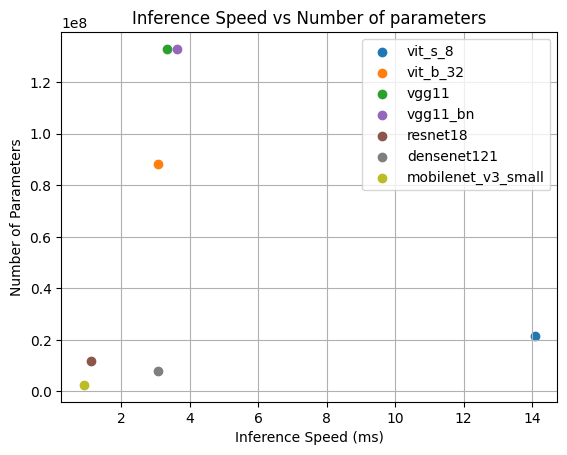

In [ ]:
# speeds = []
# params = []

for i, model_def in enumerate(model_defs):
    name = model_def.__name__
    time, _, n_params = evaluate_model(model_def, no_grad=True)
    # speeds.append(time)
    # params.append(n_params)
    time /= 8 #(8 being the batch_size)
    color = plt.colormaps.get_cmap('tab10')(i / len(model_defs))
    plt.scatter(time, n_params, label=name, color=color)


plt.title("Inference Speed vs Number of parameters")
plt.xlabel('Inference Speed (ms)')
plt.ylabel('Number of Parameters')
# plt.xscale('log')  # Use logarithmic scale for better visualization
plt.legend()
plt.grid(True)
plt.show()


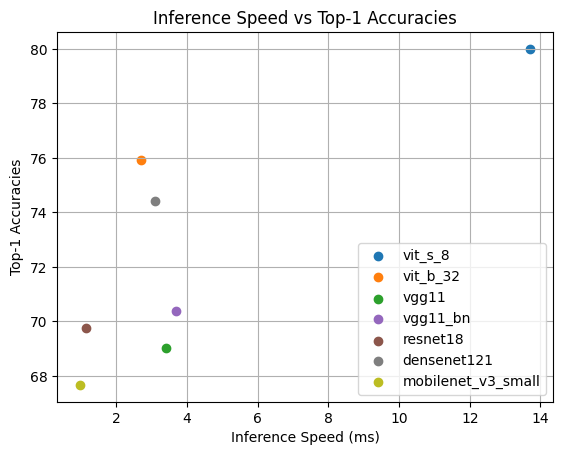

In [ ]:


for i, model_def in enumerate(model_defs):
    name = model_def.__name__
    time, vram, n_params = evaluate_model(model_def, no_grad=True)

    time /= 8
    color = plt.colormaps.get_cmap('tab10')(i / len(model_defs))
    plt.scatter(time, model_accs.get(name), label=name, color=color)


plt.title("Inference Speed vs Top-1 Accuracies")
plt.xlabel('Inference Speed (ms)')
plt.ylabel('Top-1 Accuracies')
# plt.xscale('log')  # Use logarithmic scale for better visualization
plt.legend()
plt.grid(True)
plt.show()

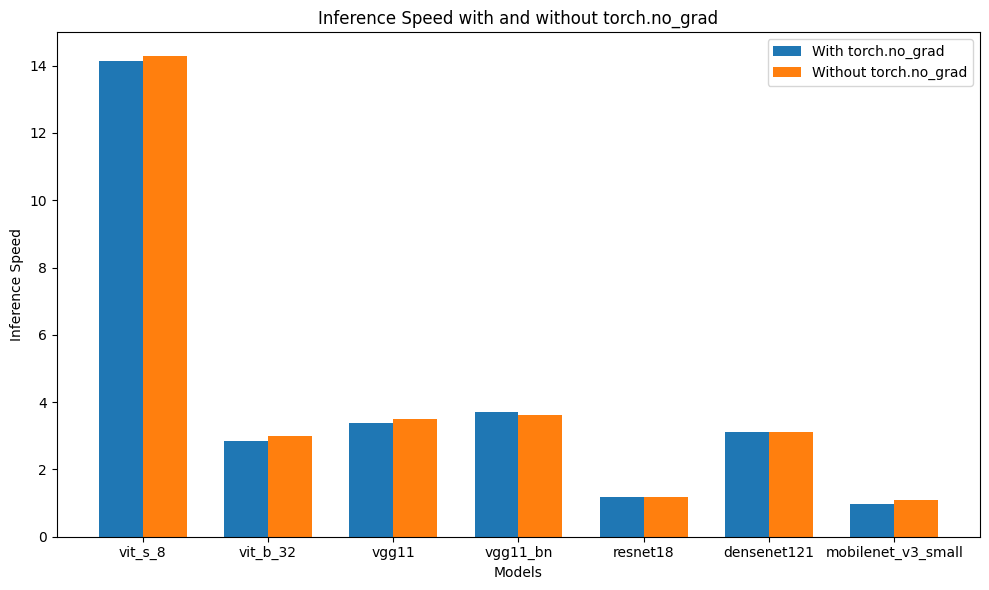

In [ ]:
## plot inference speed as a histogram with or without torch.no_grad

speeds_nograd = []
speeds_grad = []


for model_def in model_defs:
    name = model_def.__name__
    time_nograd, _, _ = evaluate_model(model_def, no_grad=True)

    time_grad, _, _ = evaluate_model(model_def, no_grad=False)


    speeds_nograd.append(time_nograd/8)
    speeds_grad.append(time_grad/8)

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = range(len(model_defs))

bar1 = ax.bar(index, speeds_nograd, bar_width, label='With torch.no_grad')
bar2 = ax.bar([i + bar_width for i in index], speeds_grad, bar_width, label='Without torch.no_grad')

ax.set_title("Inference Speed with and without torch.no_grad")
ax.set_xlabel('Models')
ax.set_ylabel('Inference Speed')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels([model_def.__name__ for model_def in model_defs])
ax.legend()

plt.tight_layout()
plt.show()

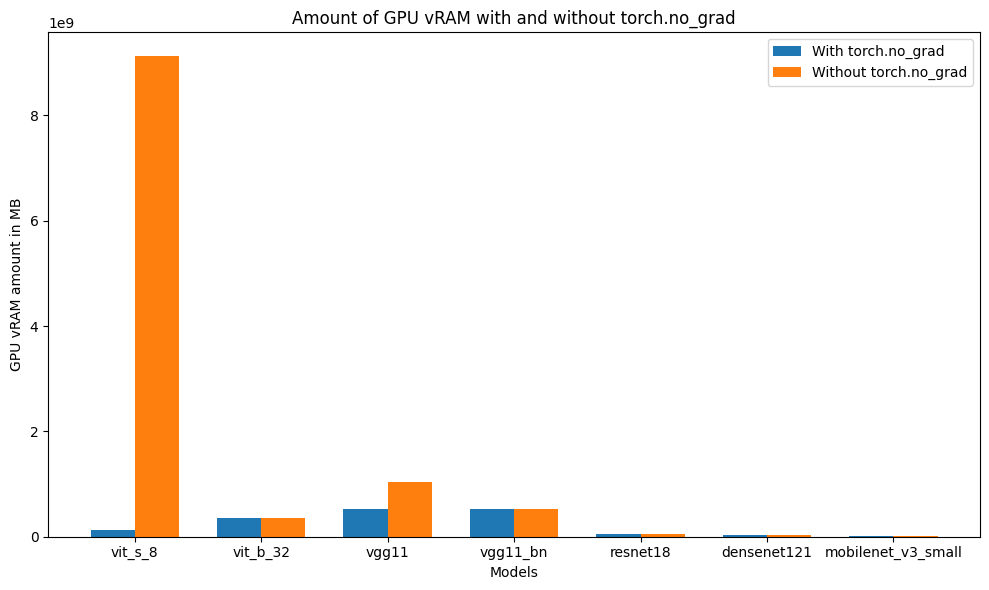

In [7]:
vrams_nograd = []
vrams_grad = []

for model_def in model_defs:
    name = model_def.__name__
    _, vram_nograd, _ = evaluate_model(model_def, no_grad=True, batch_size=64)

    _, vram_grad, _ = evaluate_model(model_def, no_grad=False, batch_size=64)

    vrams_nograd.append(vram_nograd)
    vrams_grad.append(vram_grad)

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = range(len(model_defs))

bar1 = ax.bar(index, vrams_nograd, bar_width, label='With torch.no_grad')
bar2 = ax.bar([i + bar_width for i in index], vrams_grad, bar_width, label='Without torch.no_grad')

ax.set_title("Amount of GPU vRAM with and without torch.no_grad")
ax.set_xlabel('Models')
ax.set_ylabel('GPU vRAM amount in MB')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels([model_def.__name__ for model_def in model_defs])
ax.legend()

plt.tight_layout()
plt.show()